In [1]:
import numpy as np
from scipy import stats

import pymc3 as pm

import torch
import pyro
import pyro.infer as infer
import pyro.distributions as dist
from torch.distributions import constraints

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
colors = sns.color_palette().as_hex()
n_colors = len(colors)

seed = 100
np.random.seed(seed)

# 7人の科学者

## 問題設定

- 7人の科学者がそれぞれ同じ対象からデータを採取
- 採取したデータから対象の真の値を推論する
- 7人は同じ対象を計測しているので平均は同一だが、個々人の計測能力が標準偏差に現れるとする

## データ

In [3]:
xs = np.array([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])

In [18]:
xs.mean()

3.4632857142857145

## 推論(PyMC3)

### モデルの定義

- 4-1の問題では、標準偏差の事前分布に一様分布を指定した
- ここでは、オーソドックス（と思う）アプローチである、ガンマ分布を使う

In [4]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0.0, tau=0.001)
    
    _lam = pm.Gamma('_lam', 1., 1., shape=len(xs))
    sigma = pm.Deterministic('sigma', 1.0/np.sqrt(_lam))
    #sigma = sigma = pm.Uniform('sigma', 0, 100, shape=len(xs))
    
    for i, x in enumerate(xs):
        x_obs = pm.Normal(f'x_obs_{i}', mu=mu, sigma=sigma[i], observed=x)

### 推論

In [5]:
with model:
    trace = pm.sample(1000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [_lam, mu]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 9 seconds.


### 推論結果の確認

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'_lam'}>,
        <AxesSubplot:title={'center':'_lam'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

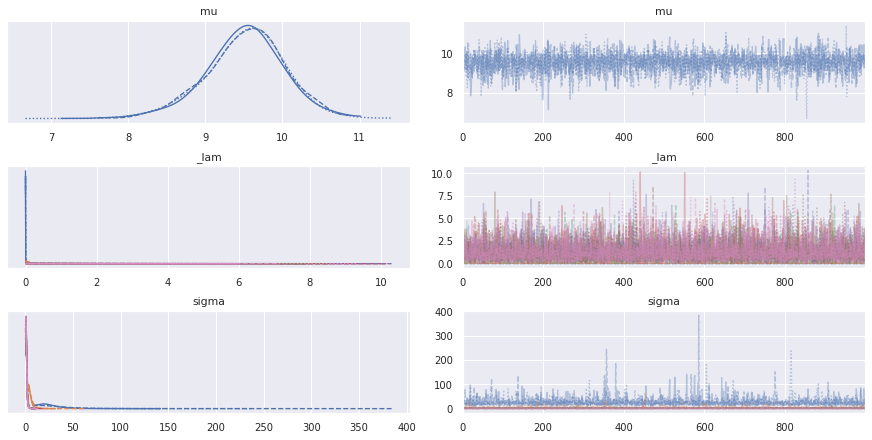

In [6]:
pm.traceplot(trace)

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'mu'}>

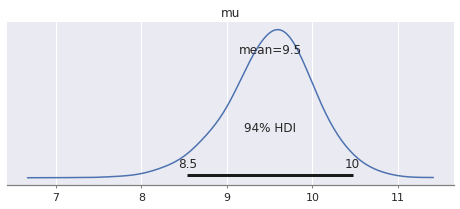

In [7]:
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1, 1)

pm.plot_posterior(trace, var_names=['mu'], ax=ax)


/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


(0.0, 100.0)

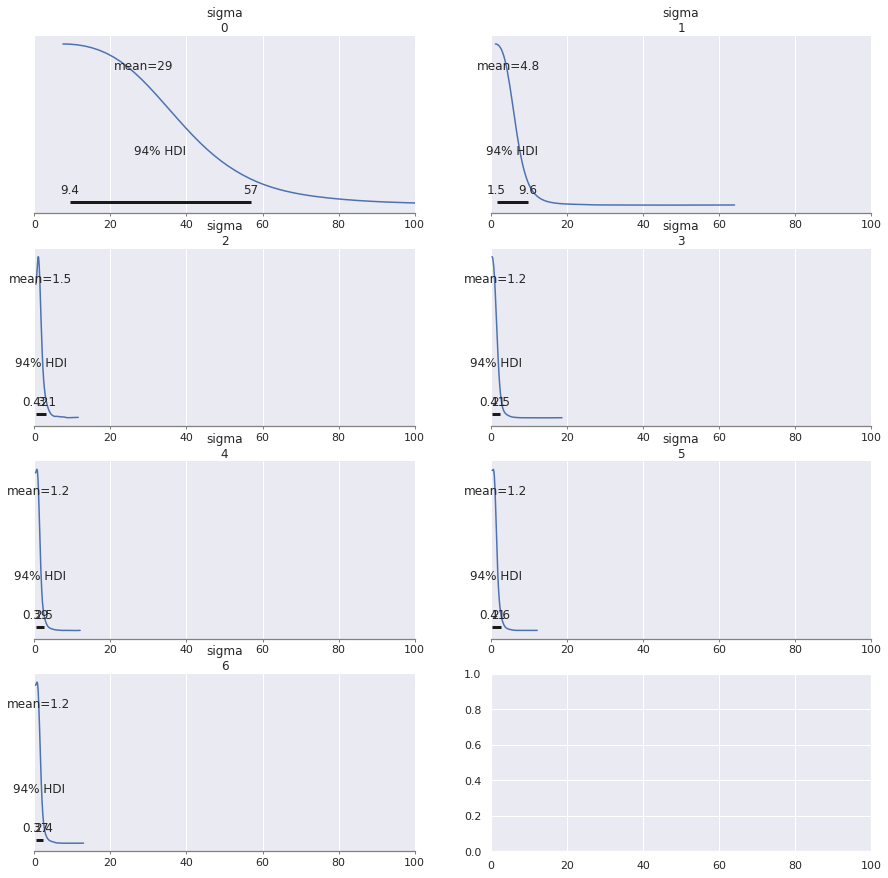

In [17]:
fig = plt.figure(figsize=(15, 15))
ax = fig.subplots(4, 2, sharex=True)

pm.plot_posterior(trace, var_names=['sigma'], ax=ax)
ax[0, 0].set_xlim(0.0, 100)


## 推論(Pyro)

### モデルの定義

- `pyro.condition`で書く方法がわからなかったので、普通に関数の中でハードコードした
  - `x_obs`のサンプル用の関数を分解するなどしたらできるかも（後でもうちょい考える）

In [11]:
def model_gauss(x):
    mu0 = torch.tensor(0.0)
    sig0 = torch.tensor(np.sqrt(1/0.0001))
    mu = pyro.sample('mu', dist.Normal(mu0, sig0))
    
    lamdas = []
    for i in range(len(x)):
        lamdas.append(pyro.sample(f'lam_{i}', dist.Gamma(torch.tensor(1.), torch.tensor(1.))))
    
    x_obs = []
    for i, x_data in enumerate(x):
        x_obs.append(pyro.sample(f'x_{i}', dist.Normal(mu, torch.sqrt(1./lamdas[i])), obs=x_data))
    return x

### 推論

- `pyro.condition`でデータを指定していないので、`mcmc.run`でデータを入力している

In [12]:
nuts_kernel = infer.NUTS(model_gauss, 
                         adapt_step_size=True, 
                         jit_compile=True, 
                         ignore_jit_warnings=True)
mcmc = infer.MCMC(nuts_kernel, 
                  num_samples=3000,
                  warmup_steps=500,
                  num_chains=1)

mcmc.run(torch.tensor(xs))


Warmup:   0%|          | 0/3500 [00:00, ?it/s]/usr/local/lib/python3.8/site-packages/torch/tensor.py:452: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  warnings.warn('Iterating over a tensor might cause the trace to be incorrect. '
Sample: 100%|██████████| 3500/3500 [01:57, 29.87it/s, step size=4.62e-01, acc. prob=0.917]


### 推論結果の確認

In [13]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      9.51      0.50      9.54      8.62     10.26   2104.36      1.00
     lam_0      0.00      0.00      0.00      0.00      0.00   4844.07      1.00
     lam_1      0.08      0.07      0.06      0.00      0.18   3226.70      1.00
     lam_2      0.83      0.75      0.62      0.00      1.80   3325.88      1.00
     lam_3      1.30      1.13      1.00      0.01      2.74   3405.56      1.00
     lam_4      1.36      1.13      1.06      0.01      2.81   3243.23      1.00
     lam_5      1.27      1.09      0.97      0.01      2.73   3777.32      1.00
     lam_6      1.23      1.08      0.94      0.01      2.60   2674.46      1.00

Number of divergences: 0


<AxesSubplot:>

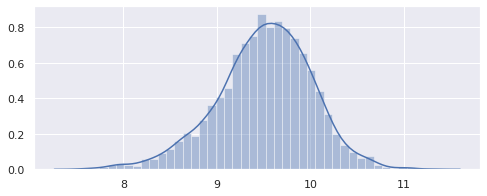

In [14]:
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1, 1)

sns.distplot(mcmc.get_samples()['mu'], ax=ax)

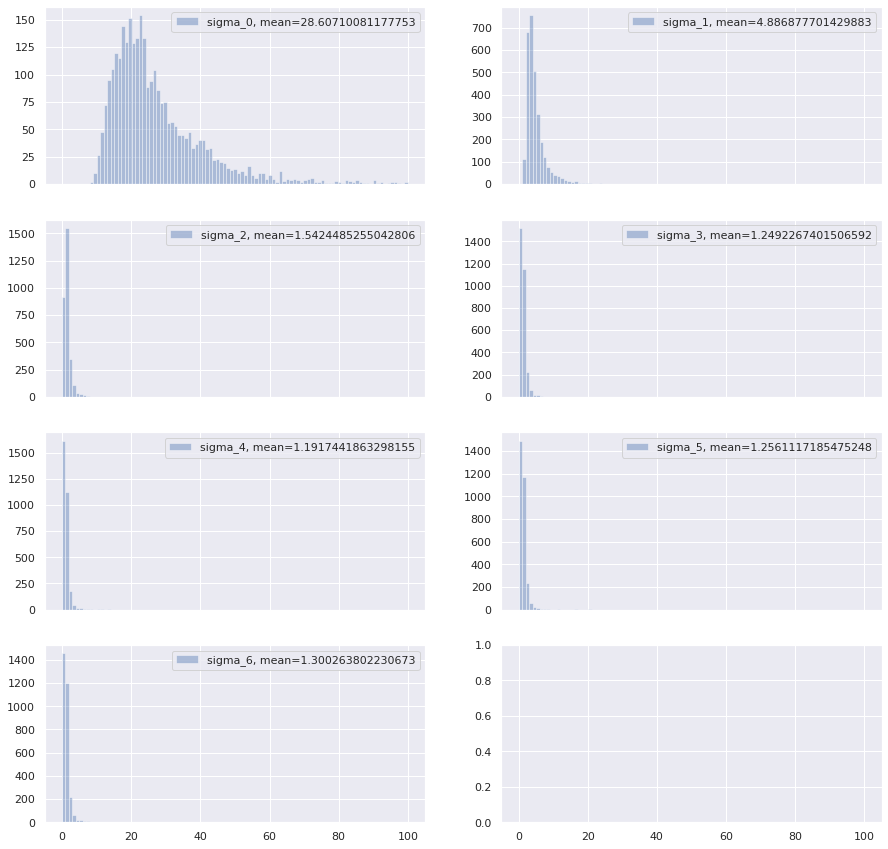

In [16]:
fig = plt.figure(figsize=(15, 15))
ax = fig.subplots(4, 2, sharex=True)
ax_rs = ax.ravel()

bins = np.linspace(0, 100, 100)
for i, _ in enumerate(xs):
    sig = np.sqrt(1./mcmc.get_samples()[f'lam_{i}'])
    sns.distplot(sig, bins=bins, ax=ax_rs[i], kde=False, 
                 label=f'sigma_{i}, mean={sig.mean()}')
    ax_rs[i].legend()
